# Analyze Text Representations
Compare text representations using TF-IDF and Bag-of-Words, then evaluate their effectiveness in a downstream clustering task. 

For this task, answer the following questions using the data in storage/*.txt.clean. Use graphs, tables, and other visualizations to support your arguments.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import re
import random
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
from modules.utils.bow import Bag_of_Words
from modules.utils.tfidf import TF_IDF
from modules.utils.text_processing import process_text
from modules.extraction.preprocessing import DocumentProcessing

from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    homogeneity_score,
    completeness_score,
    v_measure_score
)


[nltk_data] Downloading package wordnet to /Users/jk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/jk/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# Global Variables
STORAGE_DIR = '../storage/'
# SAMPLE_SIZE = 100  # No. of documents selected for processing and evaluation

In [3]:
# Helper functions
def read_text_file(file_path: str) -> str:
    """
    Reads the content of a text file.

    Args:
        file_path (str): The path to the text file.

    Returns:
        str: The content of the text file or an error message if an issue occurs.
    """
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            content = file.read()
        return content
    except FileNotFoundError:
        return f"The file at {file_path} was not found."
    except Exception as e:
        return f"An error occurred: {e}"


def cluster(X, true_labels, n_clusters):

    # Clustering with Kmeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto') #
    clusters = kmeans.fit_predict(X)

    performance = {}
    # Silhouette Score
    # Positive values indicate that data points belong to the correct clusters, indicating good clustering results.
    performance['Silhouette Score'] = silhouette_score(X, clusters)

    # Davies-Bouldin Index(DBI):
    # A lower Davies-Bouldin index indicates better clustering, as it suggests that clusters are compact and well-separated.
    performance['Davies-Bouldin Index'] = davies_bouldin_score(X, clusters)

    # ARI
    # A score closer to 1 means that the clustering is good (i.e., text from the same document is placed in the same cluster).
    performance['Adjusted Rand Index (ARI)'] = adjusted_rand_score(true_labels, clusters)

    # Homogeneity
    # A higher homogeneity score indicates that each cluster contains only parts of a single document.
    performance['homogeneity'] = homogeneity_score(true_labels, clusters)

    # Completeness:
    # A higher completeness score indicates that parts from the same document are placed in the same cluster.
    performance['completeness'] = completeness_score(true_labels, clusters)

    # V-Measure:
    # A good clustering will have high homogeneity and completeness, which is reflected in the V-Measure score.
    performance['v_measure'] = v_measure_score(true_labels, clusters)

    return clusters, performance

### Task 2 - 4

* Compare how different text pre-processing techniques (e.g., stemming vs. lemmatization vs. no processing) affect the performance of both vectorizers.
You may use these nltk classes (see modules/utils/text_processing.py):

    * `stemmer = PorterStemmer()`
    * `lemmatizer = WordNetLemmatizer()`

* Compare how different chunking and overlap parameters affect the performance of both text representation approaches. You may use to start your analysis:

    * `chunking_strategy='sentence', overlap_size=2`
    * `chunking_strategy='sentence', overlap_size=4`
    * `chunking_strategy='fixed-length', fixed_length=50, overlap_size=1`
    * `chunking_strategy='fixed-length', fixed_length=100, overlap_size=1`
    * `chunking_strategy='fixed-length', fixed_length=150, overlap_size=1`

* Compare how varying vocabulary sizes (e.g., limiting to the "top-N" most frequent words) and observe trade-offs.

> Hint: One way to compare representations is to assess how similar "neighbors" are compared to "non-neighbors." Can you think of ways to assess this algorithmically?


In [ ]:
# Load data from storage directory
doc_paths = sorted([os.path.join(STORAGE_DIR, f) for f in os.listdir(STORAGE_DIR) if f.endswith('.txt.clean')])
random.seed(42)

print(f"{len(doc_paths)} total document paths loaded for corpus.")

150 total document paths loaded for corpus.


In [ ]:
# Chunk the documents with 5 different chunking methods

chunk_methods = [
    {'chunk_strategy': 'sentence', 'num_sentences': 5, 'overlap_size': 2},
    {'chunk_strategy': 'sentence', 'num_sentences': 5, 'overlap_size': 4},
    {'chunk_strategy': 'fixed-length', 'fixed-length': 50, 'overlap_size': 1},
    {'chunk_strategy': 'fixed-length', 'fixed-length': 100, 'overlap_size': 1},
    {'chunk_strategy': 'fixed-length', 'fixed-length': 150, 'overlap_size': 1},
]

chunk_docs = []
for chunk_method in chunk_methods:
    for doc_path in doc_paths:
        # Chunking
        dp = DocumentProcessing()
        if chunk_method['chunk_strategy'] == 'sentence':
            chunks = dp.sentence_chunking(doc_path, chunk_method['num_sentences'], chunk_method['overlap_size'])
        elif chunk_method['chunk_strategy'] == 'fixed-length':
            chunks = dp.fixed_length_chunking(doc_path, chunk_method['fixed-length'], chunk_method['overlap_size'])
        else:
            raise ValueError("Invalid chunking strategy.")

        for chunk in chunks:
            chunk_docs.append({
                'chunk_strategy': chunk_method['chunk_strategy'],
                'num_sentences': chunk_method['num_sentences'] if 'num_sentences' in chunk_method else 0,
                'fixed_length': chunk_method['fixed-length'] if 'fixed-length' in chunk_method else 0,
                'overlap_size': chunk_method['overlap_size'],
                'doc_name': os.path.basename(doc_path),
                'chunk': chunk,
            })


print(f"{len(doc_paths)} documents chunked by {len(chunk_methods)} chunking methods.")


150 documents chunked by 5 chunking methods.


In [6]:
# Process data with plain, stemming and lemmatization approaches.

preprocess_methods = {
    'plain': [False, False],
    'stem': [True, False],
    'lemma': [False, True],
}

preproc_docs = []
for chunk_doc in chunk_docs:
    for preprocess_name, preprocess_params in preprocess_methods.items():
        use_stemming, use_lemmatization = preprocess_params[0], preprocess_params[1]

        preprocessed_chunk = process_text(chunk_doc['chunk'], use_stemming, use_lemmatization)
        preproc_docs.append({
            'chunk_strategy': chunk_doc['chunk_strategy'],
            'num_sentences': chunk_doc['num_sentences'],
            'fixed_length': chunk_doc['fixed_length'],
            'overlap_size': chunk_doc['overlap_size'],
            'preprocessor': preprocess_name,
            'doc_name': chunk_doc['doc_name'],
            'preprocessed_chunk': preprocessed_chunk,
        })

print(f"All chunked documents processed with plain, stemming and lemmatization.")


All chunked documents processed with plain, stemming and lemmatization.


In [7]:
# Get corpus
corpus = []
for doc_path in doc_paths:
    text = read_text_file(doc_path)
    corpus.append(read_text_file(doc_path))
print(f"{len(corpus)} documents loaded for corpus")

# Get term frequency for corpus
term_frequency, sorted_terms = {}, []
for text in corpus:
    tokens = re.findall(r'\b\w+\b', text.lower())
    token_counts = Counter(tokens)
    for token, count in token_counts.items():
        term_frequency[token] = term_frequency.get(token, 0) + count

sorted_terms = sorted(term_frequency, key=term_frequency.get, reverse=True) # sort by term frequency from largest to smallest

print(f"{len(sorted_terms)} terms sorted by term frequency.")

# Get the new vocabulary from top n terms by term frequency
vocabularies = {}
for vocab_size in [10, 50, 100, 200, 500]:
    top_n_terms = sorted_terms[:vocab_size] #  # Get the top N terms
    top_n_vocab = {value: index for index, value in enumerate(top_n_terms)} # Get the vocabulary from top N terms
    vocabularies[vocab_size] = top_n_vocab

print(f"{len(vocabularies)} vocabularies created.")

150 documents loaded for corpus
41334 terms sorted by term frequency.
5 vocabularies created.


In [8]:
vectorizers = {'tfidf': TF_IDF(), 'bow': Bag_of_Words()}

vector_docs = []
for vectorizer_name, vectorizer in vectorizers.items():
    vectorizer.fit(corpus)
    for vocab_size, vocab in vocabularies.items():
        vectorizer.vocabulary_ = vocab
        for preproc_doc in preproc_docs:
            vector = vectorizer.transform(preproc_doc['preprocessed_chunk'])
            X = list(vector.values())
            vector_docs.append({
                'chunk_strategy': preproc_doc['chunk_strategy'],
                'num_sentences': preproc_doc['num_sentences'],
                'fixed_length': preproc_doc['fixed_length'],
                'overlap_size': preproc_doc['overlap_size'],
                'preprocessor': preproc_doc['preprocessor'],
                'vectorizer': vectorizer_name,
                'vocab_size':vocab_size,
                'doc_name': preproc_doc['doc_name'],
                'vector': vector,
                'X': X,
            })
print("Vectorization finished")

Vectorization finished


In [9]:
# Display processed documents
df = pd.DataFrame(vector_docs)
df.head()

,chunk_strategy,num_sentences,fixed_length,overlap_size,preprocessor,vectorizer,vocab_size,doc_name,vector,X
0,sentence,5,0,2,plain,tfidf,10,S08_set1_a1.txt.clean,"{'the': 0.1123952135180318, 'of': 0.0259373569...","[0.1123952135180318, 0.02593735696569965, 0.04..."
1,sentence,5,0,2,stem,tfidf,10,S08_set1_a1.txt.clean,"{'the': 0.1123952135180318, 'of': 0.0259373569...","[0.1123952135180318, 0.02593735696569965, 0.04..."
2,sentence,5,0,2,lemma,tfidf,10,S08_set1_a1.txt.clean,"{'the': 0.1123952135180318, 'of': 0.0259373569...","[0.1123952135180318, 0.02593735696569965, 0.04..."
3,sentence,5,0,2,plain,tfidf,10,S08_set1_a1.txt.clean,"{'the': 0.049166395533374437, 'of': 0.02458319...","[0.049166395533374437, 0.024583197766687218, 0..."
4,sentence,5,0,2,stem,tfidf,10,S08_set1_a1.txt.clean,"{'the': 0.049166395533374437, 'of': 0.02458319...","[0.049166395533374437, 0.024583197766687218, 0..."


#### Performance Evaluation
In the previous steps, we generated document chunks with 5 chunking methods and 3 preprocessing approaches. Then, the chunks were vectorized with `tf-idf` and `bag-of-word` vectorizers with 5 vocalubary sizes. 

In the next step, the encoded document chunks will be assessed using a k-means clustering model. Better performance is indicated when chunks from the same document were grouped closely (low inner-cluster distance) and chunks from different documents were well-separated into distinct clusters (high intra-cluster distance).

Particularly, 6 performance metrics will be used for inner-cluster and intra-cluster evaluations.
* Silhouette Score: Positive values indicate that data points belong to the correct clusters, indicating good clustering results.

* Davies-Bouldin Index(DBI): A lower Davies-Bouldin index indicates better clustering, as it suggests that clusters are compact and well-separated.

* ARI: A score closer to 1 means that the clustering is good (i.e., text from the same document is placed in the same cluster).

* Homogeneity: A higher homogeneity score indicates that each cluster contains only parts of a single document.

* Completeness: A higher completeness score indicates that parts from the same document are placed in the same cluster.

* V-Measure: A good clustering will have high homogeneity and completeness, which is reflected in the V-Measure score.


In [ ]:
df = pd.DataFrame(vector_docs)
performance_results = []

for chunk_method in chunk_methods:
    num_sentences = chunk_method['num_sentences'] if 'num_sentences' in chunk_method else 0
    fixed_length = chunk_method['fixed-length'] if 'fixed-length' in chunk_method else 0

    for preproc_method in preprocess_methods:
        for vectorizer in vectorizers:
            for vocab_size in vocabularies:
                sub_df = df.loc[(df['chunk_strategy'] == chunk_method['chunk_strategy']) &
                                (df['num_sentences'] == num_sentences) &
                                (df['fixed_length'] == fixed_length) &
                                (df['overlap_size'] == chunk_method['overlap_size']) &
                                (df['preprocessor'] == preproc_method) &
                                (df['vectorizer'] == vectorizer) &
                                (df['vocab_size'] == vocab_size)
                                ]
                doc_names = sub_df['doc_name'].tolist()
                X = np.array(sub_df['X'].tolist())
                assert len(set(doc_names)) ==  len(corpus) 

                params = {
                    'chunk_strategy': chunk_method['chunk_strategy'],
                    'num_sentences': num_sentences,
                    'fixed_length': fixed_length,
                    'overlap_size': chunk_method['overlap_size'],
                    'chunk_config': f"{chunk_method['chunk_strategy']}_{num_sentences}_{fixed_length}_{chunk_method['overlap_size']}",
                    'preprocessor': preproc_method,
                    'vectorizer': vectorizer,
                    'vocab_size': vocab_size,
                }

                # clustering
                _, performance = cluster(X, doc_names, n_clusters=len(corpus)) 

                performance_results.append({**params, **performance})

performance_results = pd.DataFrame(performance_results)
performance_results.head()

,chunk_strategy,num_sentences,fixed_length,overlap_size,chunk_config,preprocessor,vectorizer,vocab_size,Silhouette Score,Davies-Bouldin Index,Adjusted Rand Index (ARI),homogeneity,completeness,v_measure
0,sentence,5,0,2,sentence_5_0_2,plain,tfidf,10,0.087352,1.764698,0.006284,0.219391,0.213871,0.216596
1,sentence,5,0,2,sentence_5_0_2,plain,tfidf,50,0.038729,2.505143,0.014558,0.266160,0.260127,0.263109
2,sentence,5,0,2,sentence_5_0_2,plain,tfidf,100,0.031625,2.641053,0.027322,0.303233,0.305009,0.304118
3,sentence,5,0,2,sentence_5_0_2,plain,tfidf,200,0.030591,2.529534,0.052386,0.355854,0.371522,0.363519
4,sentence,5,0,2,sentence_5_0_2,plain,tfidf,500,0.075725,2.040622,0.183340,0.550392,0.593324,0.571052


#### Preprocessor Comparison (Stemming vs. Lemmatization vs. Plain)

In [19]:
# Task 2: Compare performance across preprocessors for both vectorizers
metrics = performance_results.columns[8:].to_list()
preprocessor_summary = performance_results.groupby(["preprocessor", "vectorizer"])[metrics].agg(["mean", "std"])
preprocessor_summary.round(3)

Silhouette Score        Davies-Bouldin Index         \
                                    mean    std                 mean    std   
preprocessor vectorizer                                                       
lemma        bow                   0.091  0.171                2.488  0.702   
             tfidf                 0.094  0.132                2.259  0.505   
plain        bow                   0.083  0.162                2.554  0.682   
             tfidf                 0.089  0.128                2.298  0.499   
stem         bow                   0.090  0.163                2.432  0.614   
             tfidf                 0.094  0.129                2.230  0.468   

                        Adjusted Rand Index (ARI)        homogeneity         \
                                             mean    std        mean    std   
preprocessor vectorizer                                                       
lemma        bow                            0.010  0.012       0.142  0.083   
             tfidf                          0.035  0.052       0.218  0.139   
plain        bow                            0.010  0.010       0.142  0.082   
             tfidf                          0.034  0.052       0.218  0.138   
stem         bow                            0.009  0.010       0.137  0.079   
             tfidf                          0.027  0.037       0.194  0.122   

                        completeness        v_measure         
                                mean    std      mean    std  
preprocessor vectorizer                                       
lemma        bow               0.144  0.086     0.143  0.084  
             tfidf             0.224  0.150     0.221  0.144  
plain        bow               0.144  0.085     0.143  0.083  
             tfidf             0.224  0.149     0.221  0.143  
stem         bow               0.139  0.081     0.138  0.080  
             tfidf             0.200  0.134     0.197  0.128

**Interpretation**
* Lemmatization tends to give slightly better performance across most metrics:
    * Best or tied-best in Silhouette, ARI, homogeneity, completeness, and v-measure.
* Stemming has slightly better Davies-Bouldin Index (lower is better), but worse ARI and v-measure. 
* Plain (no preprocessing) is almost indistinguishable from lemmatization in this dataset but has slightly worse Davies-Bouldin Index.

The differences are subtle overall, so visualizations and interactions (e.g., with vocab size and chunking) will help clarify.

#### Chunker Comparison


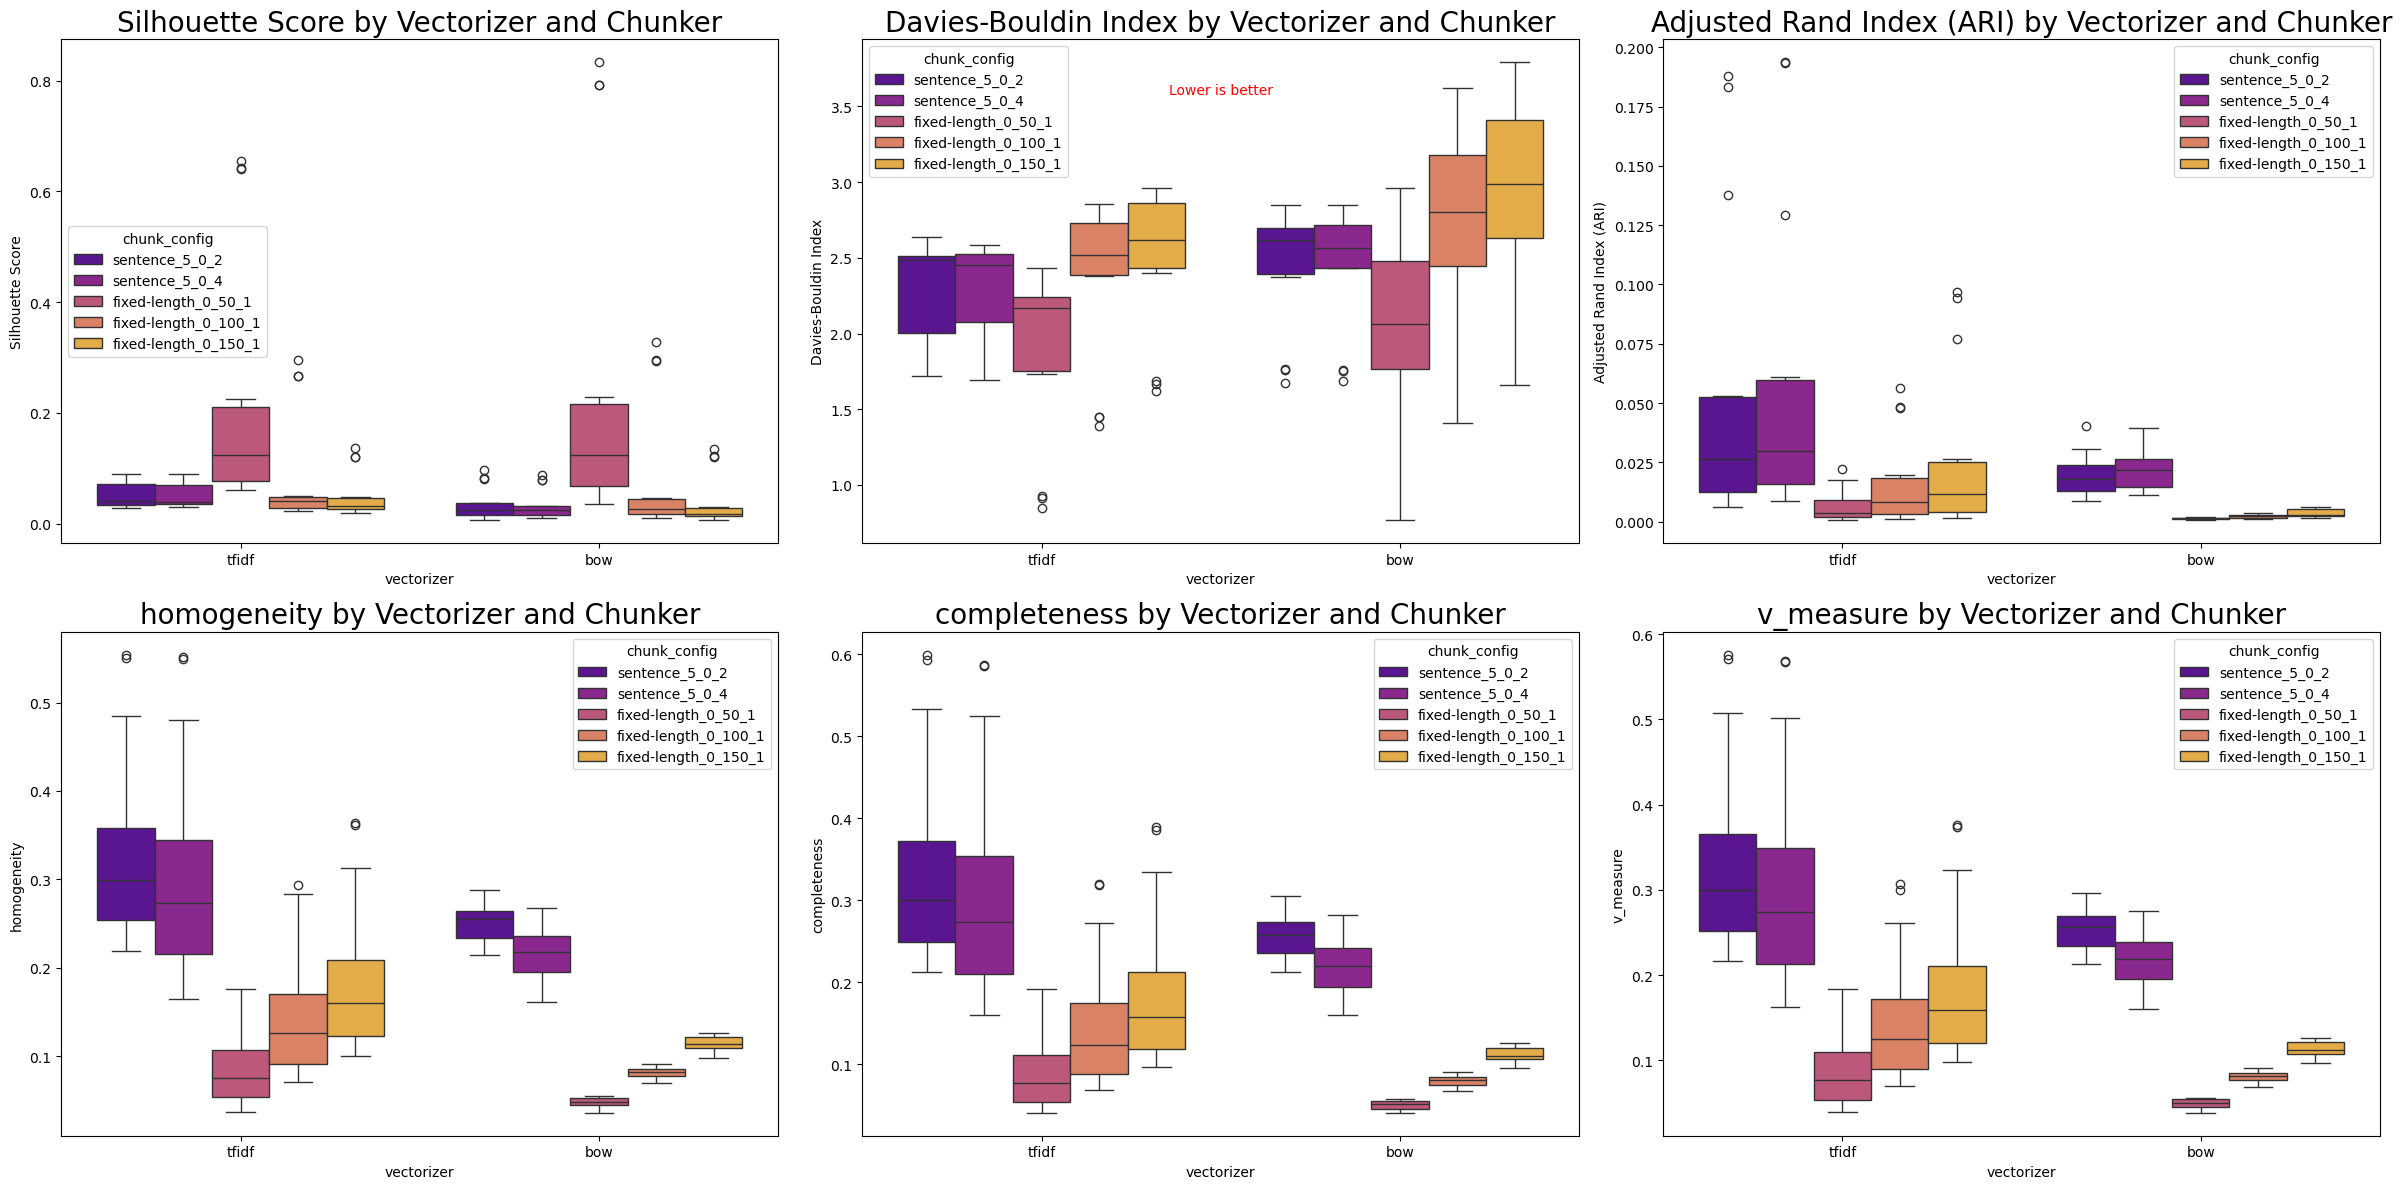

In [ ]:
# Generate plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.boxplot(data=performance_results, x='vectorizer', y=metric, hue='chunk_config', ax=axes[i], palette='plasma')
    axes[i].set_title(f'{metric} by Vectorizer and Chunker', fontsize=20)

    if metric == 'Davies-Bouldin Index':
            axes[i].text(0.5, 0.9, 'Lower is better', ha='center', va='center', transform=axes[i].transAxes, fontsize=10, color='red')

plt.tight_layout()
plt.show()

**Interpretation**

For both vectorizers: 
* **Extrinsic Metrics (ARI, V-Measure, etc.)**: The `sentence` chunking strategy is dramatically better. This shows that when using TF-IDF, which weighs words by their importance in the corpus, sentence-based chunks are far more effective at preserving the document's meaning for clustering.
* **Intrinsic Metrics (Silhouette, Davies-Bouldin)**: The `fixed-length` chunking strategy performs better. This is likely due to the uniform size of the chunks creating geometrically neater, though less contextually meaningful, clusters.


**Conclusion**

The choice of vectorizer—whether the more sophisticated TF-IDF or the simpler Bag-of-Words—does not change the fundamental conclusion about the chunking methods. In both scenarios:
* If the goal is for the clusters to accurately reflect the original document groupings, sentence chunking is the best strategy.
* If the goal is to optimize for geometric cluster properties (density and separation) without regard for the actual content, fixed-length chunking would be chosen.
This consistency across different vectorization methods strengthens the recommendation to use sentence-based chunking for this type of clustering task.

#### Vocabulary Size Comparison

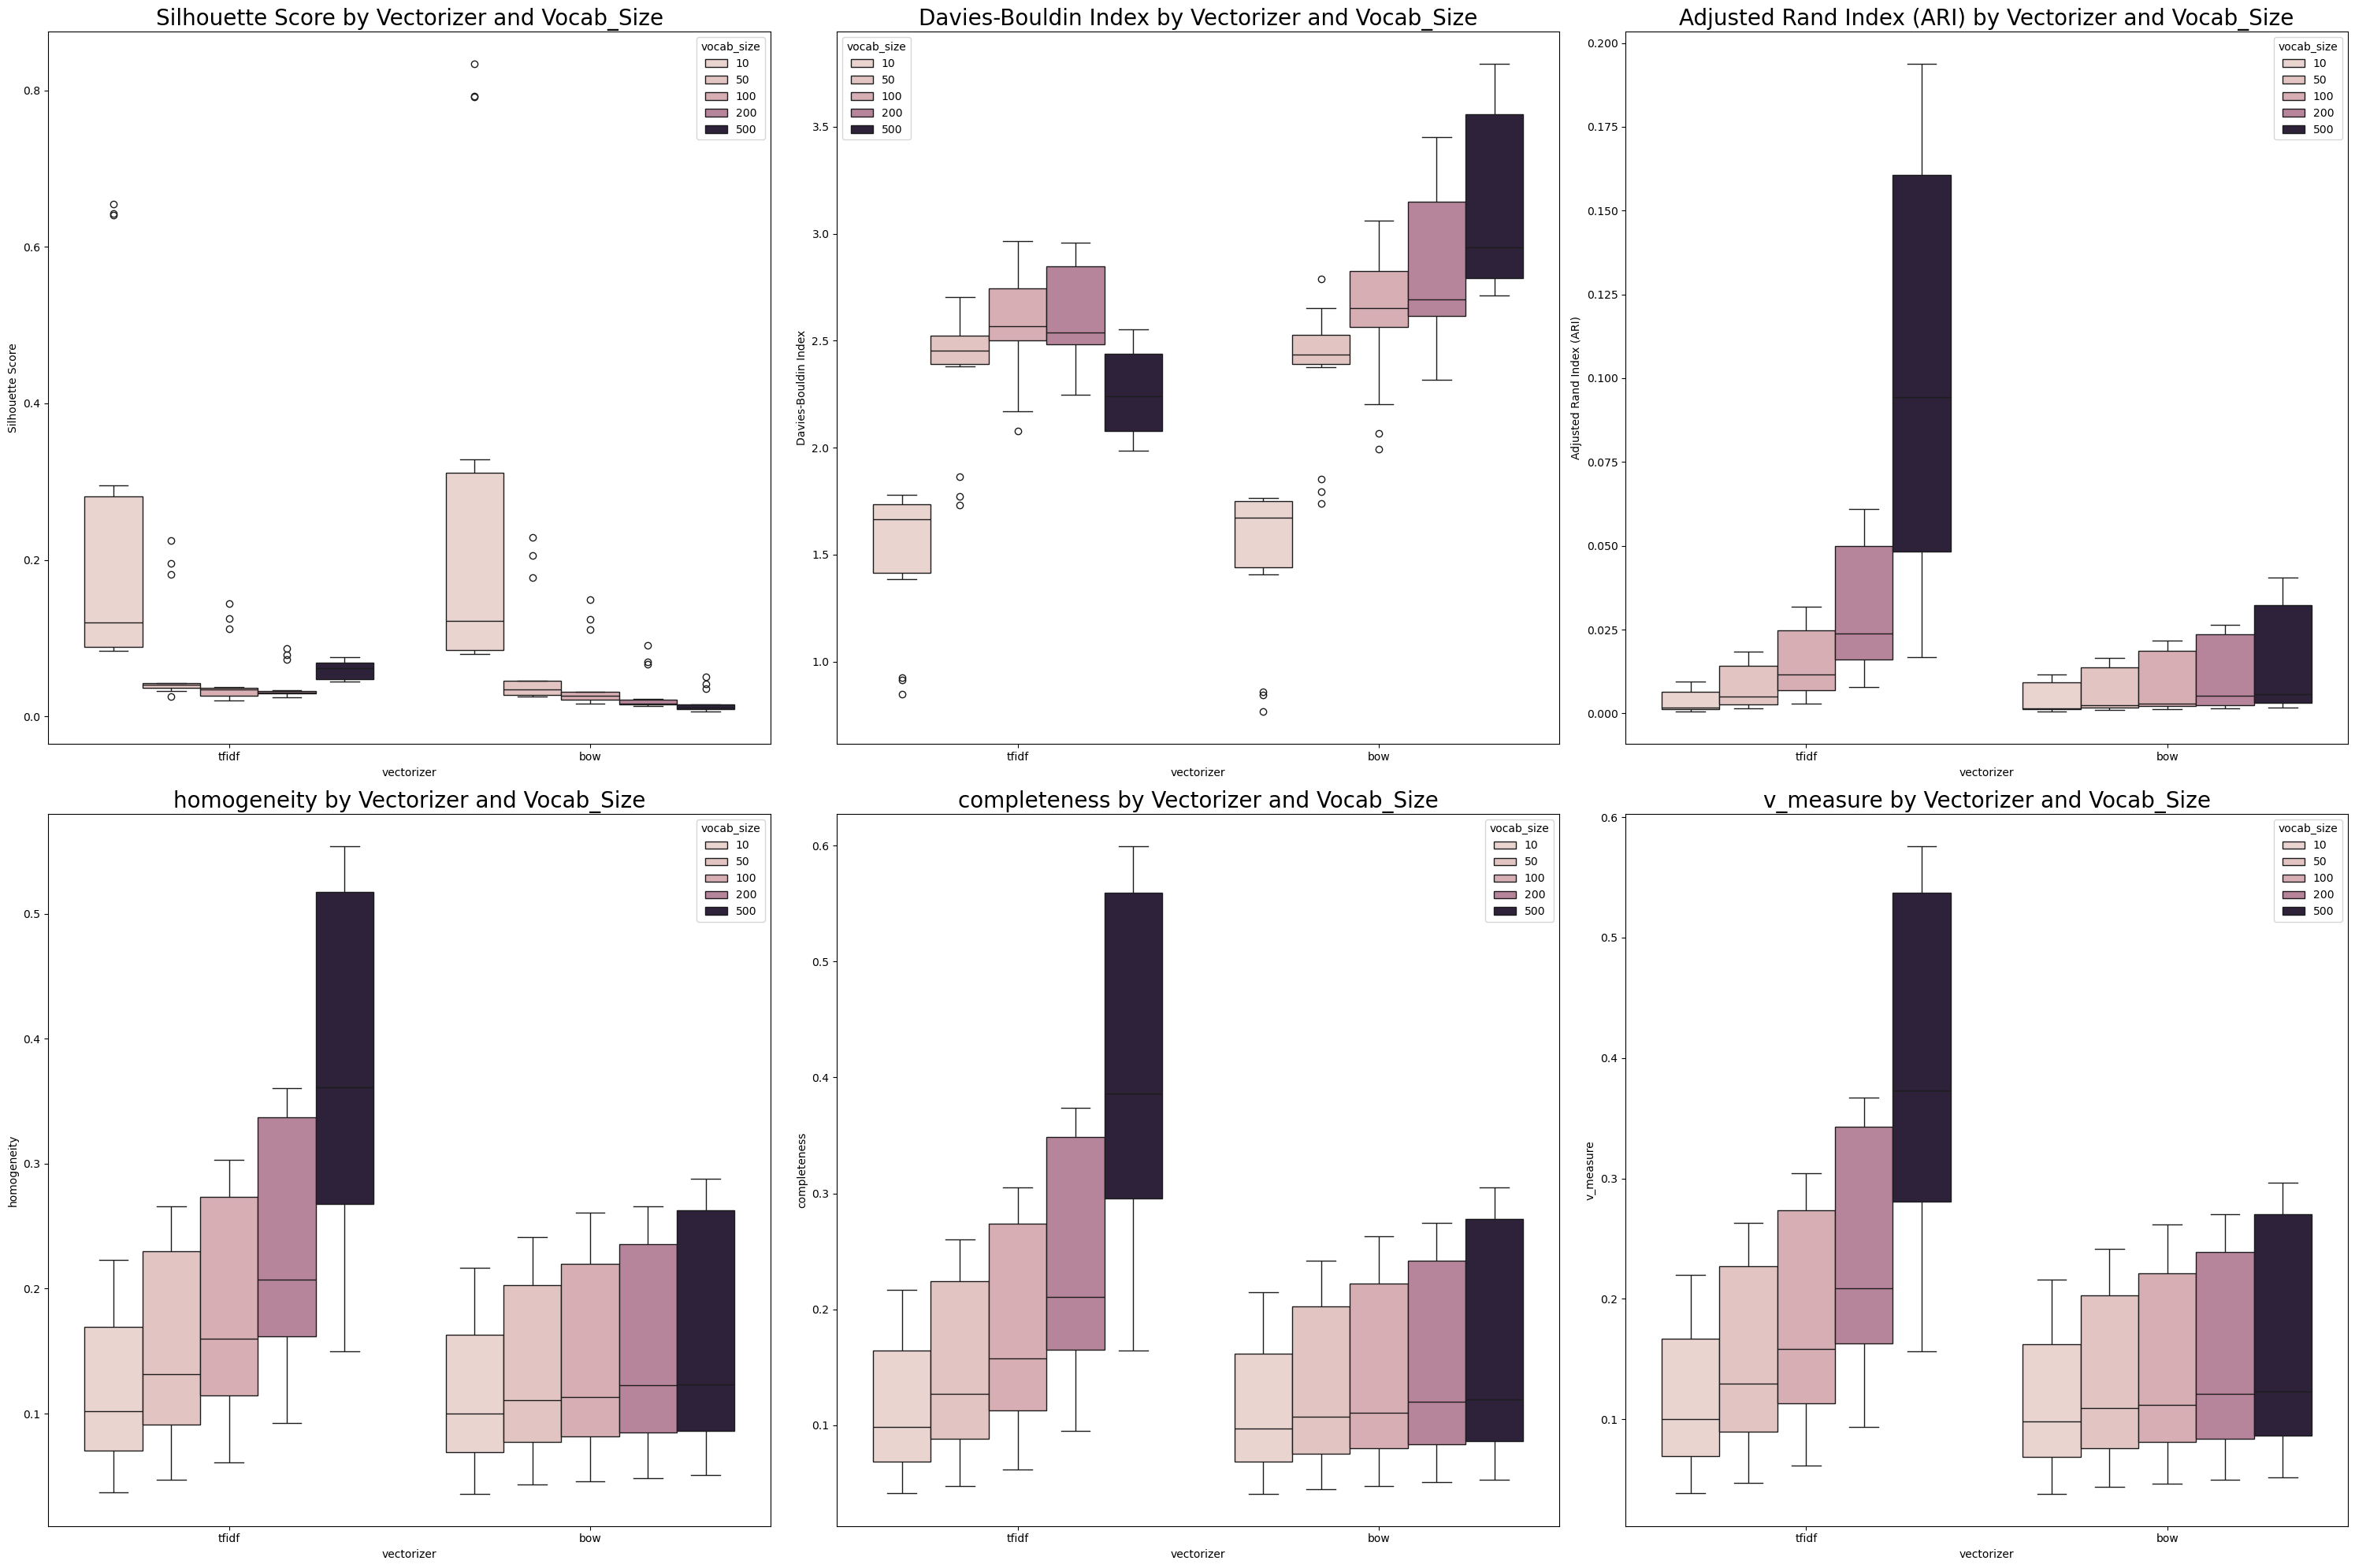

In [29]:
# Generate plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 20))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.boxplot(data=performance_results, x='vectorizer', y=metric, hue='vocab_size', ax=axes[i])
    axes[i].set_title(f'{metric} by Vectorizer and Vocab_Size', fontsize=20)

plt.tight_layout()
plt.show()

Again, TF-IDF shows better performance than BoW in general. Both vectorizers benefit from increased vocabulary size. 

**TF-IDF Vectorizer**
* TF-IDF shows a strong gain from 10 → 500 vocab size, with metric improvement for ARI, Homogeneity, Completeness, V-Measure. It indicates that richer representations improve cluster alignment,

**Bag-of-Words Vectorizer**
* BoW sees slight improvement with more vocabulary but is still worse than TF-IDF.

Particularly, we noticed the **unexpected strong performance at small vocabulary sizes** (e.g., vocab_size = 10) in some metrics like Silhouette Score and Davies-Bouldin. Here's further analysis:

* Silhouette Score and Davies-Bouldin Index (DBI) are purely geometric and do not rely on any ground truth labels. With a very small vocabulary (e.g., 10), vector representations become very sparse and simple, emphasizing only the most common/high-frequency terms. Thus, documents containing any rare terms will likely be ignored, leading to small groups of very similar chunks, which may inflate performance by Silhouette Score and DBI, as the former favors clusters that are tight and well-separated; and the latter penalizes overlapping clusters.

* An optimized geometric criteria does not always mean better clustering, as it reduced dimensionality leading to less noise -- but also less signal:
    * Overfit to frequent stopword-level features, which may not distinguish between different documents.
    * Fail to align with actual ground-truth identities — this is reflected in lower ARI, homogeneity, and completeness at small vocab sizes.

#### Overall Impact

To evaluate the relative importance of each factor, we will quantify how much the choice for that factor can change the final outcome.

To do this, the **Adjusted Rand Index (ARI)** will be used as the performance metric and calculated the range of outcomes for each factor. A wide range means the choices within that factor have a high impact, while a narrow range means the choices have a low impact.

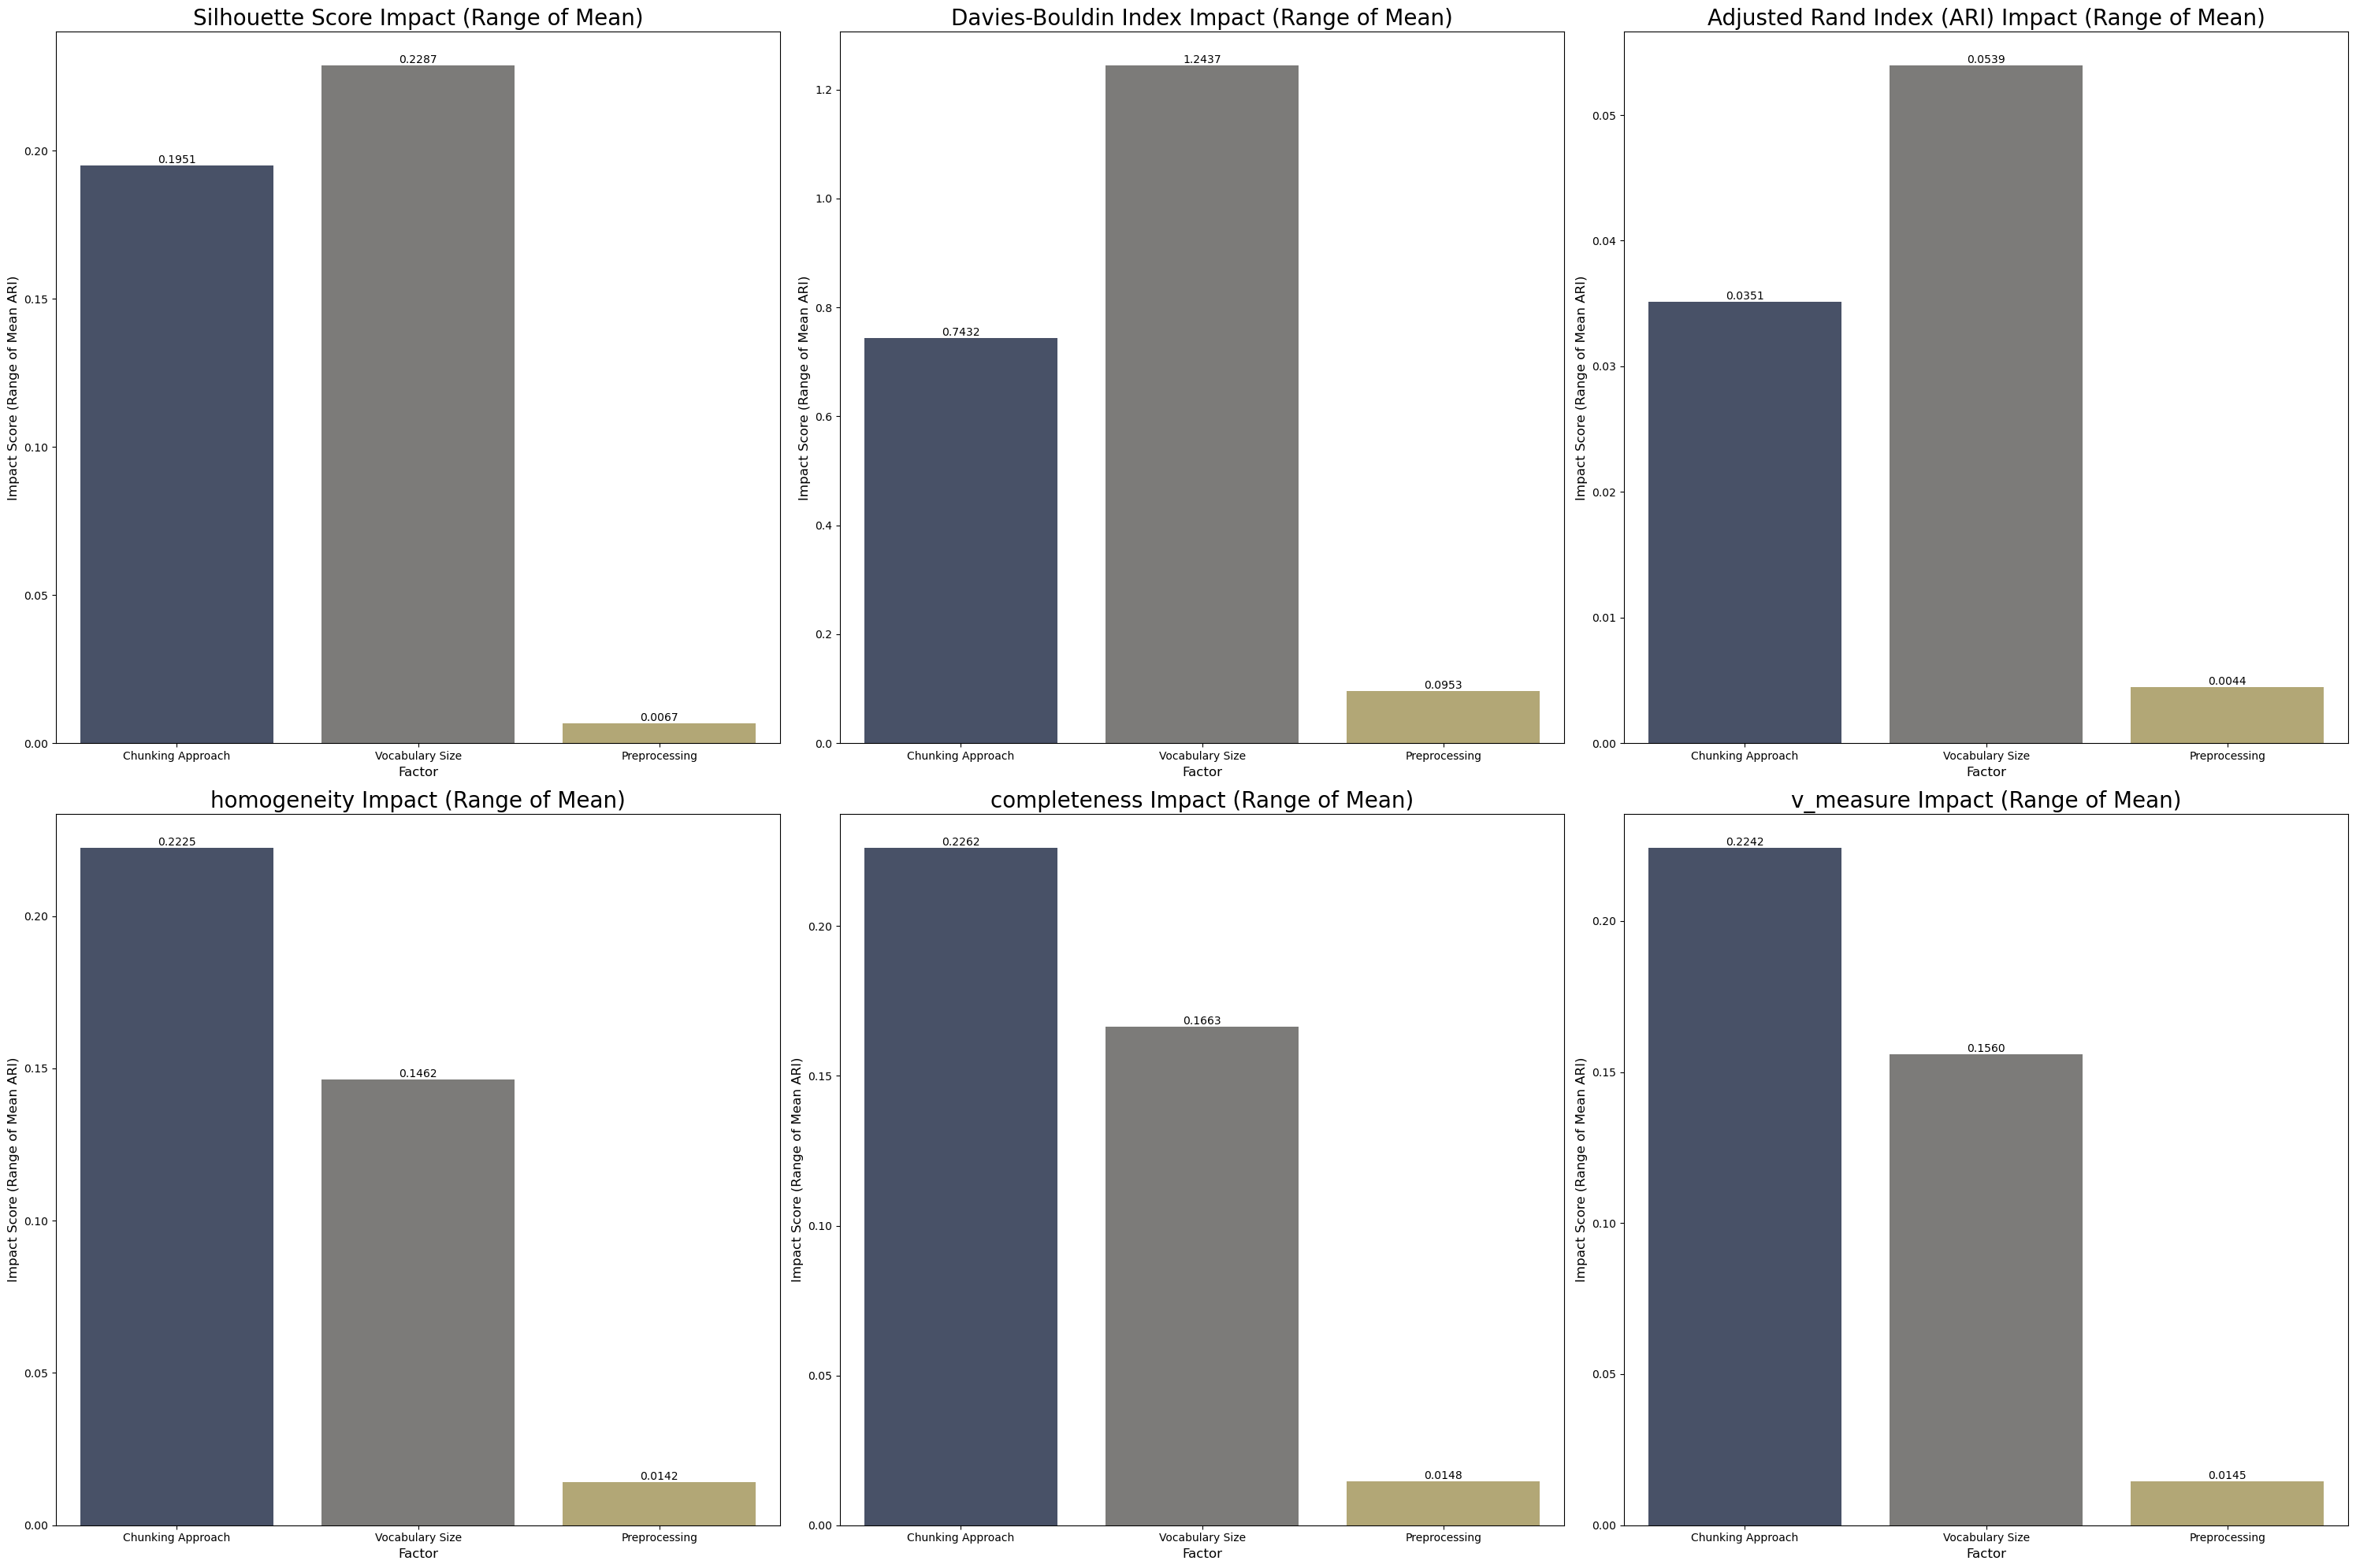

In [ ]:
# Calculate the mean ARI for each category within the three factors

# Visualize the impact scores
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 20))
axes = axes.flatten()
for i, metric in enumerate(metrics):
    chunking_means = performance_results.groupby('chunk_config')[metric].mean()
    vocab_means = performance_results.groupby('vocab_size')[metric].mean()
    preprocessing_means = performance_results.groupby('preprocessor')[metric].mean()

    impact_scores = {
        'Chunking Approach': chunking_means.max() - chunking_means.min(),
        'Vocabulary Size': vocab_means.max() - vocab_means.min(),
        'Preprocessing': preprocessing_means.max() - preprocessing_means.min()
    }
    impact_df = pd.DataFrame(list(impact_scores.items()), columns=['Factor', 'Impact (Range of Mean)'])
    
    sns.barplot(x='Factor', y='Impact (Range of Mean)', hue='Factor', data=impact_df, palette='cividis', ax=axes[i])
    axes[i].set_title(f'{metric} Impact (Range of Mean)', fontsize=20)
    axes[i].set_xlabel('Factor', fontsize=12)
    axes[i].set_ylabel('Impact Score (Range of Mean ARI)', fontsize=12)

    # Add annotations to the bars
    for index, row in impact_df.iterrows():
        axes[i].text(index, row['Impact (Range of Mean)'], f"{row['Impact (Range of Mean)']:.4f}", color='black', ha="center", va="bottom")
        
plt.tight_layout()
plt.show()

**Overall Summary**

* For Intrinsic Quality, `Vocabulary` Size is King.
    
    When looking at the intrinsic metrics, which measure the geometric quality of the clusters without knowing the "true" labels:

    * Davies-Bouldin Index: The impact of Vocabulary Size is massive, far exceeding any other factor for any other metric.
    * Silhouette Score: Vocabulary Size also has the highest impact. This means if your primary goal is to create dense, well-separated clusters, your most critical decision is the size of the vocabulary you use.

* For Matching Ground Truth, `Chunking Strategy` is Most Important.
    
    When looking at the extrinsic metrics, which measure how well your clusters match the original file labels:

    * Adjusted Rand Index (ARI), Homogeneity, Completeness, and V-Measure: For all of these, the Chunking Approach consistently has the highest impact score. Vocabulary Size is also very important and has a significant impact, but the choice of chunking strategy has a slight edge.

* `Preprocessing` is Consistently the Least Critical Factor.
    
    Across every single metric, the impact of your preprocessing choice (stemming, lemmatization, or none) is dwarfed by the other two factors. This is the most consistent trend in the data and strongly suggests that you will get the most benefit by focusing your tuning efforts elsewhere.


As our primary goal is for the clustering to align with the original file structure (as measured by ARI, Homogeneity, etc.), the best approach is to:

* Use sentence as the chunking strategy.
* Use the largest vocabulary size as possible.
* Don't spend excessive time fine-tuning the Preprocessing step. Its effect is minimal.